# Time Series Fundamentals with TensorFlow + Milestone Project 3: BitPredict

The purpose of this notebook is to cover the time series fundamentals with TensorFlow, as well as build a time series project to predict the price of Bitcoin based on historical price data.

## Get data

I am going to be using the historical price data from Coindesk. I will be using data from 05/18/2021 and before for this project.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-08-31 20:50:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2023-08-31 20:50:54 (7.24 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series data with pandas

In [2]:
# Import with pandas
import pandas as pd
# Read in Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and set col 1 to datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
# How many samples
len(df)

2787

The dataset provides the historical price of Bitcoin every day for the past ~8 years, so there is only 2787 samples.

Typically, deep learning models like as much data as possible.

A smaller number of samples is often for time series problems. The **seasonality** of a time series dataset is the number of samples per year. The dataset I am using has a seasonality of daily or value of 365.

In [4]:
# Separate closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})

In [5]:
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


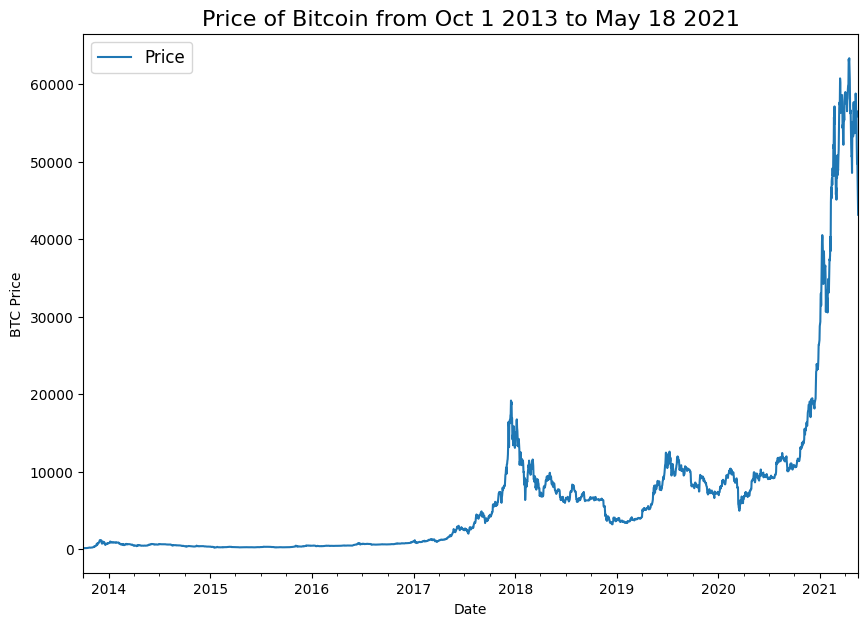

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from Oct 1 2013 to May 18 2021", fontsize=16)
plt.legend(fontsize=12)

## Importing time series data with Python's CSV module

In [7]:
# Importing and formatting historical bitcoin data with Python (instead of pandas)
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

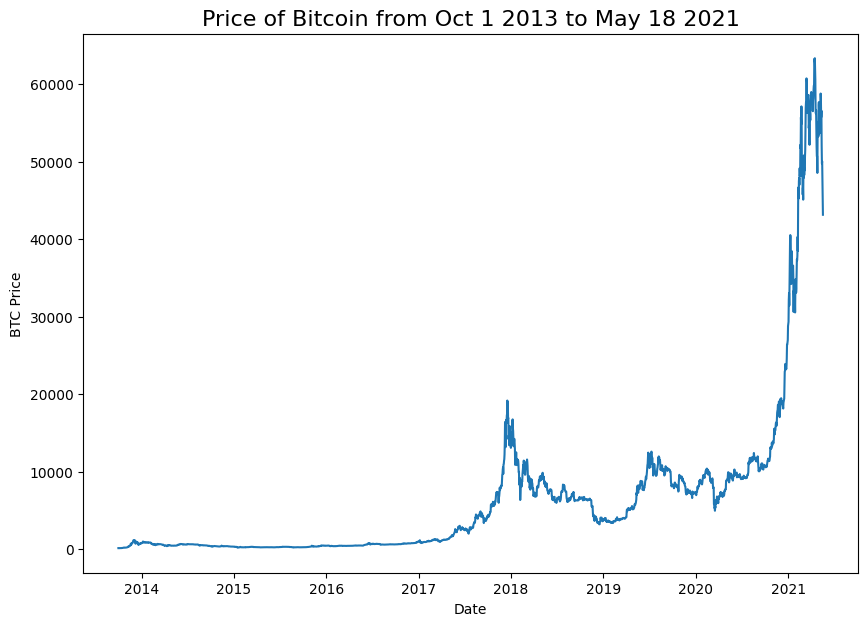

In [8]:
# Plot from csv
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from Oct 1 2013 to May 18 2021", fontsize=16)
plt.xlabel("Date")

## Create train and test sets of our time series data

### Creating training and test sets with time series data (the wrong way)

In [9]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

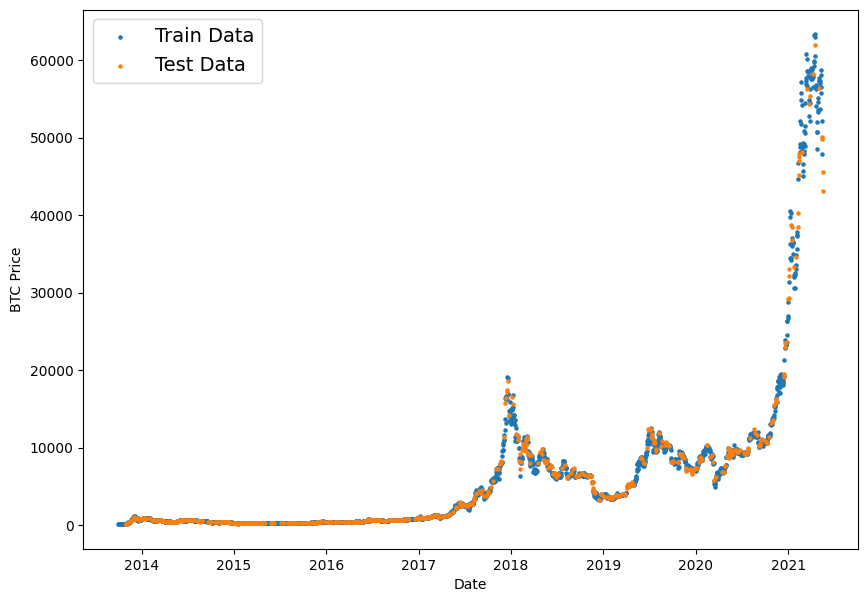

In [11]:
# Plotting the splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train Data")
plt.scatter(X_test, y_test, s=5, label="Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Creating training and test sets with time series data (the right way)

In [12]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the splt)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

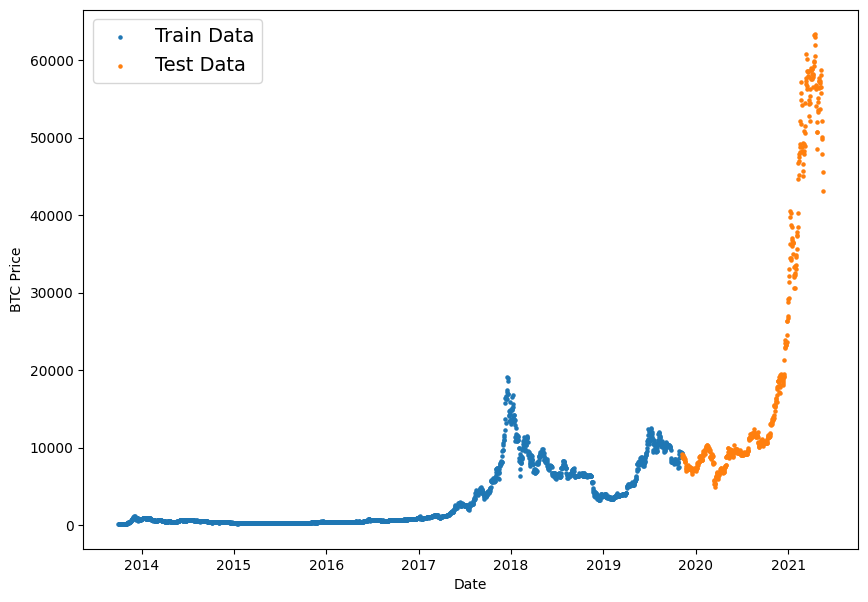

In [13]:
# Plot correctly made splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train Data")
plt.scatter(X_test, y_test, s=5, label="Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

In [14]:
# Create plotting function
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (series of points in time) against values.

  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (similar to start but for the end)
  label : label to show on plot about values, default None
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

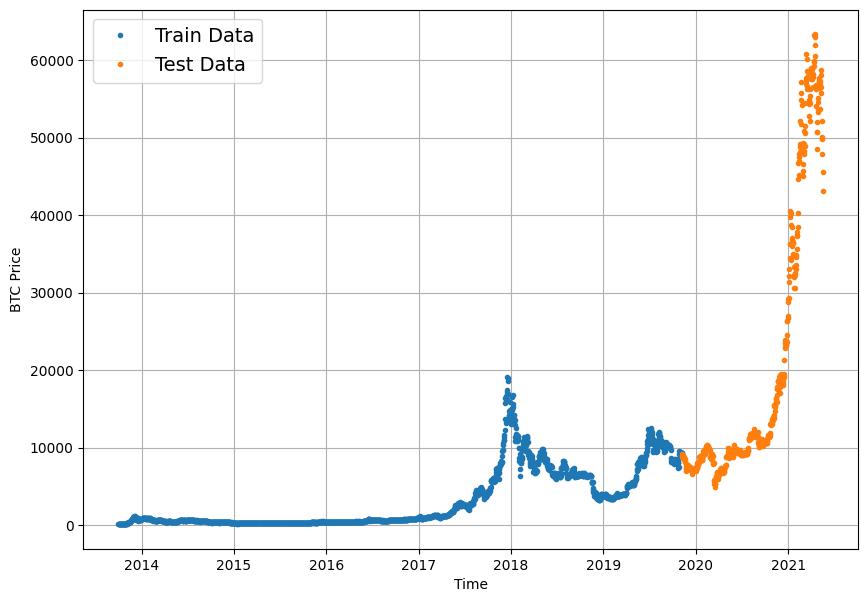

In [15]:
# Test function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train Data")
plot_time_series(timesteps=X_test, values=y_test, label="Test Data")

## Modelling Experiments

* **Horizon** = number of timesteps into the future you're going to predict
* **Window size** = number of timesteps you're going to use to predict **horizon**

Modelling experiments I'm running:
* 0. Naive model (baseline)
* 1. Dense model, horizon = 1, window = 7
* 2. Same as 1, horizon = 1, window = 30
* 3. Same as 1, horizon = 7, window = 30
* 4. Conv1D
* 5. LSTM
* 6. Same as 1 (but with multivariate data)
* 7. N-BEATS algorithm
* 8. Ensemble (multiple models stacked together)
* 9. Future prediction model
* 10. Same as 1 (but with turkey data introduced)

## Model 0. Naive forecast (baseline)

Formula for naive forecasting:

$$\hat{y}_{t} = y_{t-1}$$

* The prediction at timestep t is equal to the value at timestep t-1
* This is for horizon of 1



In [16]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

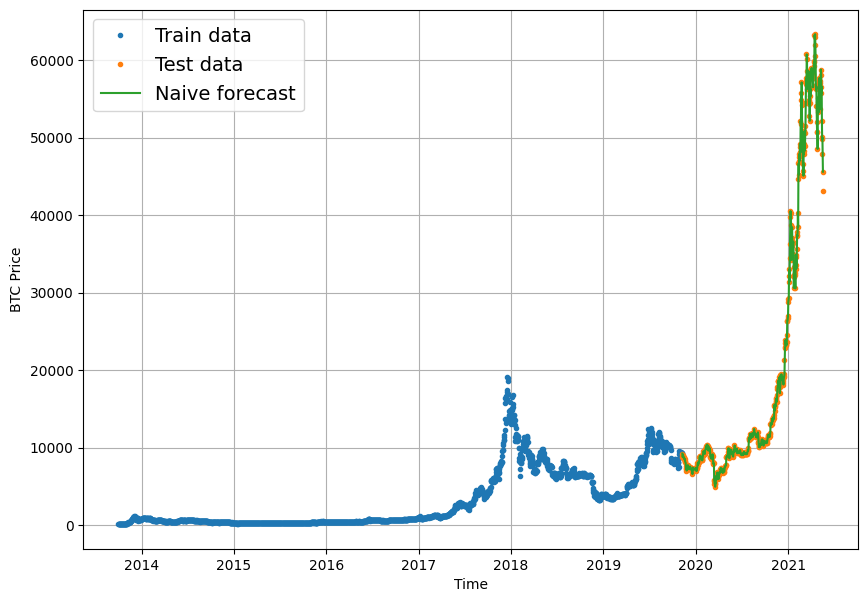

In [17]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast")

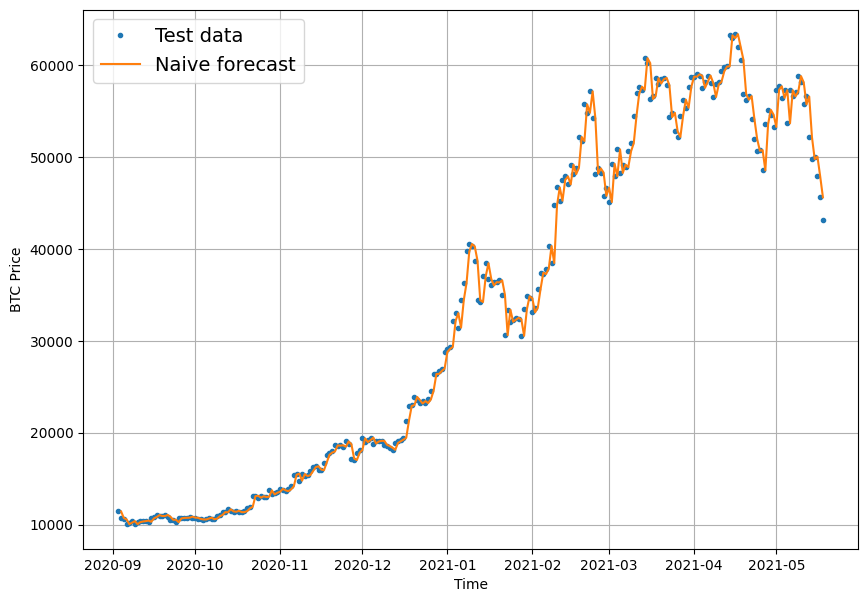

In [18]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

## Evaluating a time series model

Since I am predicting a number, this is a regression problem.

Because this is a regression problem, I'll need some regression-like metrics. Some common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all, **lower is better**.



In [19]:
import tensorflow as tf

In [20]:
# MASE implementation
def mean_absolute_scaled_error (y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:1]))

  return mae / mae_naive_no_season

In [23]:
# Evaluate preds function
def evaluate_preds(y_true, y_pred):
  # Ensure float32
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.04742711}

For naive forecast, each prediction is on average ~$567 different than the actual price.

## Format Data Part 2: Windowing dataset

Windowing is a method to turn a time series dataset into a **supervised learning problem**.

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

In [25]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [26]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Need a way to make windows for an entire time series.

I can write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6, 7],
[1, 2, 3, 4, 5, 6, 7, 8],
[2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

In [28]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [31]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into training and test sets

I could've windowed the existing training and test splits, however, with the nature of windowing (windowing often requires an offset at some point in the data), it usually works better to window the data first, then split it into training and test sets.

In [32]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [34]:
# First 5 samples of training windows and labels
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [35]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint


In [36]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense Model - window = 7, horizon = 1

In [37]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name to save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
 1/18 [>.............................] - ETA: 1:48 - loss: 1582.6360 - mae: 1582.6360

18/18 [==============================] - 7s 60ms/step - loss: 528.8613 - mae: 528.8613 - val_loss: 1202.2355 - val_mae: 1202.2355
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 161.0161 - mae: 161.0161

18/18 [==============================] - 1s 32ms/step - loss: 218.8576 - mae: 218.8576 - val_loss: 1006.9454 - val_mae: 1006.9454
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 181.2888 - mae: 181.2888 - val_loss: 1221.9891 - val_mae: 1221.9891
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 186.7984 - mae: 186.7984

18/18 [==============================] - 1s 47ms/step - loss: 169.4529 - mae: 169.4529 - val_loss: 907.8376 - val_mae: 907.8376
Epoch 5/100
14/18 [======================>.......] - ETA: 0s - loss: 161.4006 - mae: 161.4006

18/18 [==============================] - 1s 46ms/step - loss: 158.2442 - mae: 158.2442 - val_loss: 869.0038 - val_mae: 869.0038
Epoch 6/100
18/18 [==============================] - 0s 8ms/step - loss: 156.0481 - mae: 156.0481 - val_loss: 893.1276 - val_mae: 893.1276
Epoch 7/100
13/18 [====================>.........] - ETA: 0s - loss: 160.4817 - mae: 160.4817

18/18 [==============================] - 1s 44ms/step - loss: 154.5860 - mae: 154.5860 - val_loss: 836.1161 - val_mae: 836.1161
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 154.1943 - mae: 154.1943

18/18 [==============================] - 1s 32ms/step - loss: 154.1943 - mae: 154.1943 - val_loss: 825.3105 - val_mae: 825.3105
Epoch 9/100
17/18 [===========================>..] - ETA: 0s - loss: 150.9074 - mae: 150.9074

18/18 [==============================] - 1s 34ms/step - loss: 150.9575 - mae: 150.9575 - val_loss: 795.4509 - val_mae: 795.4509
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 145.2081 - mae: 145.2081

18/18 [==============================] - 1s 32ms/step - loss: 143.5905 - mae: 143.5905 - val_loss: 779.2632 - val_mae: 779.2632
Epoch 11/100
18/18 [==============================] - 0s 5ms/step - loss: 140.0076 - mae: 140.0076 - val_loss: 802.7048 - val_mae: 802.7048
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 139.2321 - mae: 139.2321 - val_loss: 798.2558 - val_mae: 798.2558
Epoch 13/100
16/18 [=========================>....] - ETA: 0s - loss: 137.9694 - mae: 137.9694

18/18 [==============================] - 1s 33ms/step - loss: 139.1539 - mae: 139.1539 - val_loss: 766.2735 - val_mae: 766.2735
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 133.4692 - mae: 133.4692

18/18 [==============================] - 1s 32ms/step - loss: 133.4692 - mae: 133.4692 - val_loss: 760.6019 - val_mae: 760.6019
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 131.7982 - mae: 131.7982

18/18 [==============================] - 1s 31ms/step - loss: 133.9236 - mae: 133.9236 - val_loss: 717.1984 - val_mae: 717.1984
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 129.3447 - mae: 129.3447 - val_loss: 744.9016 - val_mae: 744.9016
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 128.2964 - mae: 128.2964 - val_loss: 732.2150 - val_mae: 732.2150
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 127.5598 - mae: 127.5598

18/18 [==============================] - 1s 31ms/step - loss: 126.6987 - mae: 126.6987 - val_loss: 689.2093 - val_mae: 689.2093
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 125.4756 - mae: 125.4756 - val_loss: 708.7591 - val_mae: 708.7591
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 123.0417 - mae: 123.0417

18/18 [==============================] - 1s 31ms/step - loss: 123.5474 - mae: 123.5474 - val_loss: 682.6121 - val_mae: 682.6121
Epoch 21/100
 1/18 [>.............................] - ETA: 0s - loss: 157.6987 - mae: 157.6987

18/18 [==============================] - 1s 30ms/step - loss: 125.7304 - mae: 125.7304 - val_loss: 664.0504 - val_mae: 664.0504
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 123.4976 - mae: 123.4976 - val_loss: 672.6333 - val_mae: 672.6333
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 126.3531 - mae: 126.3531 - val_loss: 670.8151 - val_mae: 670.8151
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 129.5587 - mae: 129.5587

18/18 [==============================] - 1s 29ms/step - loss: 122.8767 - mae: 122.8767 - val_loss: 651.6979 - val_mae: 651.6979
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 124.6858 - mae: 124.6858

18/18 [==============================] - 1s 30ms/step - loss: 119.7201 - mae: 119.7201 - val_loss: 644.8638 - val_mae: 644.8638
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 120.8163 - mae: 120.8163

18/18 [==============================] - 1s 48ms/step - loss: 121.0674 - mae: 121.0674 - val_loss: 639.4534 - val_mae: 639.4534
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 161.2981 - mae: 161.2981

18/18 [==============================] - 1s 33ms/step - loss: 120.4690 - mae: 120.4690 - val_loss: 633.0543 - val_mae: 633.0543
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 108.4343 - mae: 108.4343

18/18 [==============================] - 1s 31ms/step - loss: 117.0813 - mae: 117.0813 - val_loss: 629.0966 - val_mae: 629.0966
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 116.8948 - mae: 116.8948 - val_loss: 635.6572 - val_mae: 635.6572
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 122.5240 - mae: 122.5240 - val_loss: 631.8523 - val_mae: 631.8523
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 122.8039 - mae: 122.8039

18/18 [==============================] - 1s 30ms/step - loss: 115.5426 - mae: 115.5426 - val_loss: 618.3294 - val_mae: 618.3294
Epoch 32/100
15/18 [========================>.....] - ETA: 0s - loss: 114.7746 - mae: 114.7746

18/18 [==============================] - 1s 38ms/step - loss: 114.0279 - mae: 114.0279 - val_loss: 615.9098 - val_mae: 615.9098
Epoch 33/100
18/18 [==============================] - 0s 8ms/step - loss: 115.0864 - mae: 115.0864 - val_loss: 697.3742 - val_mae: 697.3742
Epoch 34/100
18/18 [==============================] - 0s 7ms/step - loss: 115.9883 - mae: 115.9883 - val_loss: 622.9061 - val_mae: 622.9061
Epoch 35/100
14/18 [======================>.......] - ETA: 0s - loss: 116.2830 - mae: 116.2830

18/18 [==============================] - 1s 47ms/step - loss: 113.0381 - mae: 113.0381 - val_loss: 615.4563 - val_mae: 615.4563
Epoch 36/100
11/18 [=================>............] - ETA: 0s - loss: 114.3643 - mae: 114.3643

18/18 [==============================] - 1s 48ms/step - loss: 116.9060 - mae: 116.9060 - val_loss: 605.0031 - val_mae: 605.0031
Epoch 37/100
14/18 [======================>.......] - ETA: 0s - loss: 115.7342 - mae: 115.7342

18/18 [==============================] - 1s 34ms/step - loss: 113.9814 - mae: 113.9814 - val_loss: 603.3113 - val_mae: 603.3113
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 113.7436 - mae: 113.7436 - val_loss: 616.6613 - val_mae: 616.6613
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 132.4802 - mae: 132.4802

18/18 [==============================] - 1s 31ms/step - loss: 115.0500 - mae: 115.0500 - val_loss: 599.9106 - val_mae: 599.9106
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 111.4277 - mae: 111.4277 - val_loss: 609.2213 - val_mae: 609.2213
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 108.1511 - mae: 108.1511

18/18 [==============================] - 1s 32ms/step - loss: 110.6952 - mae: 110.6952 - val_loss: 597.1364 - val_mae: 597.1364
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 118.1859 - mae: 118.1859 - val_loss: 598.2413 - val_mae: 598.2413
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 114.2875 - mae: 114.2875 - val_loss: 665.2594 - val_mae: 665.2594
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 74.7804 - mae: 74.7804

18/18 [==============================] - 1s 30ms/step - loss: 114.4476 - mae: 114.4476 - val_loss: 591.0921 - val_mae: 591.0921
Epoch 45/100
18/18 [==============================] - 0s 5ms/step - loss: 109.9984 - mae: 109.9984 - val_loss: 663.4246 - val_mae: 663.4246
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 111.2639 - mae: 111.2639 - val_loss: 622.9357 - val_mae: 622.9357
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 111.6887 - mae: 111.6887 - val_loss: 639.3884 - val_mae: 639.3884
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 111.2720 - mae: 111.2720 - val_loss: 637.8585 - val_mae: 637.8585
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 164.6393 - mae: 164.6393

18/18 [==============================] - 1s 31ms/step - loss: 113.5151 - mae: 113.5151 - val_loss: 587.2237 - val_mae: 587.2237
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0028 - mae: 110.0028 - val_loss: 614.1025 - val_mae: 614.1025
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 109.0237 - mae: 109.0237 - val_loss: 589.0442 - val_mae: 589.0442
Epoch 52/100
 1/18 [>.............................] - ETA: 0s - loss: 120.0592 - mae: 120.0592

18/18 [==============================] - 1s 30ms/step - loss: 111.1880 - mae: 111.1880 - val_loss: 581.6896 - val_mae: 581.6896
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 111.5214 - mae: 111.5214 - val_loss: 642.2961 - val_mae: 642.2961
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 111.8111 - mae: 111.8111 - val_loss: 587.3907 - val_mae: 587.3907
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 113.4068 - mae: 113.4068 - val_loss: 603.1438 - val_mae: 603.1438
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 112.5387 - mae: 112.5387 - val_loss: 822.9985 - val_mae: 822.9985
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 134.4277 - mae: 134.4277 - val_loss: 759.1283 - val_mae: 759.1283
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 118.5509 - mae: 118.5509 - val_loss: 589.6130 - val_mae: 589.6130
Epoch 59/100
18/18 [============

18/18 [==============================] - 1s 31ms/step - loss: 108.4588 - mae: 108.4588 - val_loss: 576.0295 - val_mae: 576.0295
Epoch 62/100
 1/18 [>.............................] - ETA: 0s - loss: 72.5913 - mae: 72.5913

18/18 [==============================] - 1s 32ms/step - loss: 106.4189 - mae: 106.4189 - val_loss: 574.7795 - val_mae: 574.7795
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 111.1653 - mae: 111.1653 - val_loss: 649.4651 - val_mae: 649.4651
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 110.6443 - mae: 110.6443 - val_loss: 594.3591 - val_mae: 594.3591
Epoch 65/100
17/18 [===========================>..] - ETA: 0s - loss: 109.4078 - mae: 109.4078

18/18 [==============================] - 1s 33ms/step - loss: 108.3881 - mae: 108.3881 - val_loss: 574.0773 - val_mae: 574.0773
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 107.1872 - mae: 107.1872 - val_loss: 576.6943 - val_mae: 576.6943
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 106.7478 - mae: 106.7478 - val_loss: 679.3824 - val_mae: 679.3824
Epoch 68/100
 1/18 [>.............................] - ETA: 0s - loss: 73.6151 - mae: 73.6151

18/18 [==============================] - 1s 32ms/step - loss: 108.4568 - mae: 108.4568 - val_loss: 573.4696 - val_mae: 573.4696
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 110.0918 - mae: 110.0918 - val_loss: 680.2191 - val_mae: 680.2191
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 120.1951 - mae: 120.1951 - val_loss: 584.1421 - val_mae: 584.1421
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 107.4754 - mae: 107.4754 - val_loss: 574.1223 - val_mae: 574.1223
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 111.0815 - mae: 111.0815 - val_loss: 586.0785 - val_mae: 586.0785
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 110.1577 - mae: 110.1577 - val_loss: 578.0365 - val_mae: 578.0365
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 109.3280 - mae: 109.3280 - val_loss: 608.9812 - val_mae: 608.9812
Epoch 75/100
18/18 [============

18/18 [==============================] - 1s 31ms/step - loss: 106.2929 - mae: 106.2929 - val_loss: 570.0197 - val_mae: 570.0197
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 112.4956 - mae: 112.4956 - val_loss: 619.7048 - val_mae: 619.7048
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 115.9723 - mae: 115.9723 - val_loss: 659.8898 - val_mae: 659.8898
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 112.6337 - mae: 112.6337 - val_loss: 570.0344 - val_mae: 570.0344
Epoch 85/100
 1/18 [>.............................] - ETA: 0s - loss: 83.7959 - mae: 83.7959

18/18 [==============================] - 1s 63ms/step - loss: 106.8053 - mae: 106.8053 - val_loss: 569.0922 - val_mae: 569.0922
Epoch 86/100
12/18 [===================>..........] - ETA: 0s - loss: 100.7967 - mae: 100.7967

18/18 [==============================] - 1s 46ms/step - loss: 106.2713 - mae: 106.2713 - val_loss: 568.9117 - val_mae: 568.9117
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 105.0261 - mae: 105.0261 - val_loss: 616.5850 - val_mae: 616.5850
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 107.1087 - mae: 107.1087 - val_loss: 587.5477 - val_mae: 587.5477
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 105.8905 - mae: 105.8905 - val_loss: 583.4106 - val_mae: 583.4106
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 107.1620 - mae: 107.1620 - val_loss: 576.9276 - val_mae: 576.9276
Epoch 91/100
18/18 [==============================] - 0s 6ms/step - loss: 110.7189 - mae: 110.7189 - val_loss: 593.8617 - val_mae: 593.8617
Epoch 92/100
 1/18 [>.............................] - ETA: 0s - loss: 89.0173 - mae: 89.0173

18/18 [==============================] - 1s 31ms/step - loss: 110.7182 - mae: 110.7182 - val_loss: 568.4803 - val_mae: 568.4803
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 115.7193 - mae: 115.7193 - val_loss: 618.8070 - val_mae: 618.8070
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 110.8500 - mae: 110.8500 - val_loss: 573.4387 - val_mae: 573.4387
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 105.4417 - mae: 105.4417 - val_loss: 572.3729 - val_mae: 572.3729
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 106.1057 - mae: 106.1057 - val_loss: 583.4973 - val_mae: 583.4973
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 105.3580 - mae: 105.3580 - val_loss: 585.8444 - val_mae: 585.8444
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 107.2484 - mae: 107.2484 - val_loss: 568.7828 - val_mae: 568.7828
Epoch 99/100
 1/18 [>...........

18/18 [==============================] - 1s 32ms/step - loss: 107.6382 - mae: 107.6382 - val_loss: 567.3467 - val_mae: 567.3467
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 111.6419 - mae: 111.6419 - val_loss: 671.9689 - val_mae: 671.9689


In [38]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 671.9690 - mae: 671.9690


[671.968994140625, 671.968994140625]

In [39]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 567.3466 - mae: 567.3466


[567.3465576171875, 567.3465576171875]

## Making forecasts with a model (on the test dataset)

Need to write a function which:
1. Takes in a trained model
2. Takes in some input data
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [40]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [41]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 1s 6ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8832.878 , 8761.554 , 8994.539 , 8740.312 , 8726.093 , 8716.33  ,
        8655.279 , 8498.402 , 8439.53  , 8498.6455], dtype=float32)>)

In [42]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 567.34656,
 'mse': 1167292.2,
 'rmse': 1080.413,
 'mape': 2.5426316,
 'mase': 0.04729637}

In [43]:
# Compare to naive forecast
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.04742711}

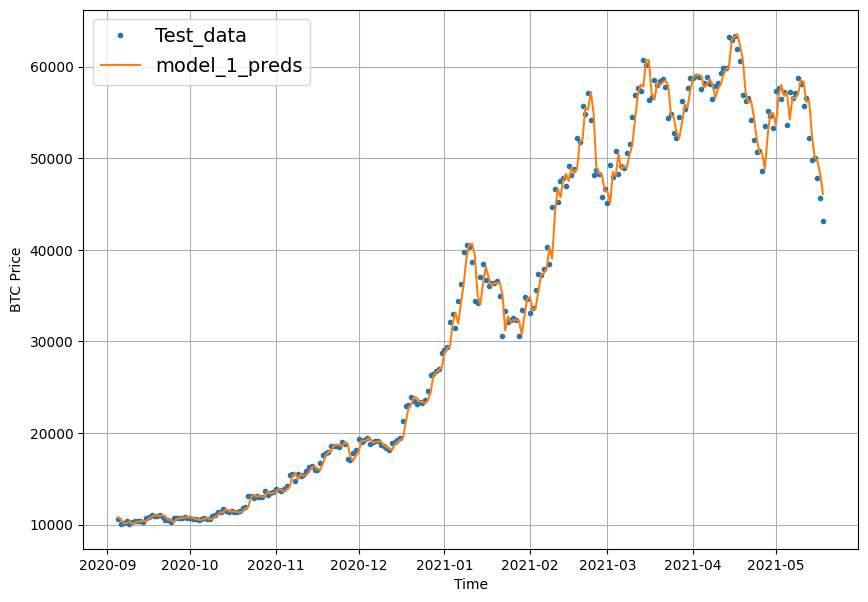

In [44]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense - window = 30, horizon = 1

In [45]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [46]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [47]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [48]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [49]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 688.4663


688.46630859375

In [50]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 608.3493


608.3493041992188

In [51]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [52]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.34937,
 'mse': 1303944.6,
 'rmse': 1141.9039,
 'mape': 2.7246644,
 'mase': 0.050245337}

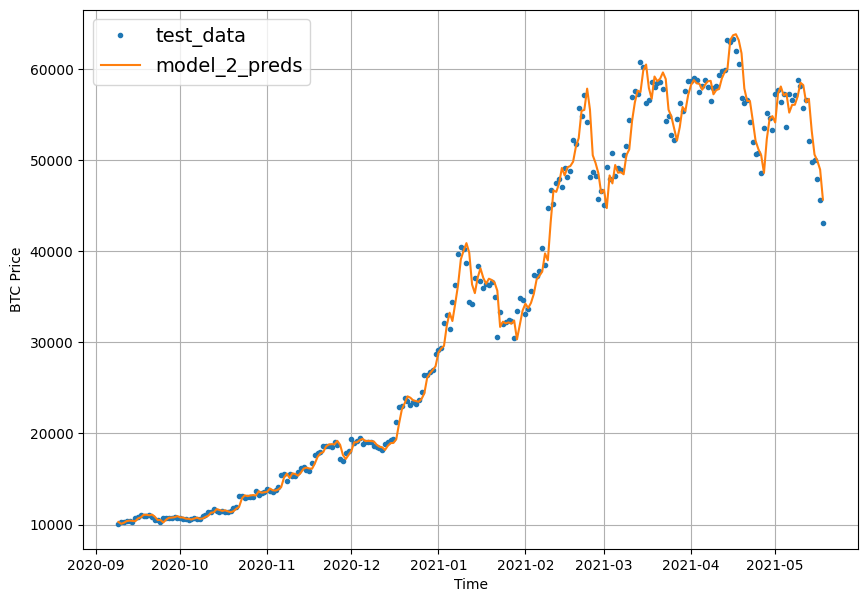

In [53]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense - window = 30, horizon = 7

In [54]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [55]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [56]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [57]:
# Evaluate model 3
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1426.5569


1426.556884765625

In [58]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1248.2584


1248.2584228515625

In [59]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9413.919, 9523.121, 9168.354, 9565.985, 9803.502, 9748.212,
        9491.841],
       [9142.829, 9354.998, 8833.343, 9349.238, 9494.173, 9389.351,
        9434.202],
       [8884.641, 9272.991, 8836.996, 9152.331, 9221.796, 9329.375,
        9478.249],
       [8981.483, 9346.881, 9085.283, 9306.801, 9330.24 , 9346.157,
        9481.128],
       [8741.714, 9070.101, 8746.123, 9026.97 , 9188.939, 9113.671,
        9202.388]], dtype=float32)>

In [60]:
# Calculate model_3 results - these are going to be multi-dimensional because
# I'm trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  737.4898 ,   534.19196,   519.92316,   641.6874 ,   463.97543,
          608.58307,   571.37683,   492.71213,   532.8818 ,   667.74347,
          897.6803 ,   849.8577 ,   877.0547 ,   897.9345 ,   664.66754,
          267.23264,   212.31795,   310.9228 ,   210.69608,   229.6077 ,
          219.38832,   264.8148 ,   381.1686 ,   266.1898 ,   152.491  ,
          170.67766,   149.53635,   223.08998,   210.74149,   166.75955,
          260.47873,   380.581  ,   399.29416,   404.17682,   314.78354,
          318.2772 ,   344.04807,   205.97537,   220.74951,   194.66225,
          496.74567,    93.52009,   111.47245,   167.50119,   192.30531,
           94.08538,    90.10345,   155.73752,   139.18652,   179.37975,
          150.9435 ,   135.62395,   224.54324,   125.14711,   258.6363 ,
          326.0402 ,   532.30457,   410.35287,   481.44427,   563.7692 ,
          248.13658,   270.0223 ,   225.60289,   295.0931 ,   326.32535,
          487.12598,   384.04053,   430.3317

## Make the evaluation function work for larger horizons

In [61]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [62]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1248.2585,
 'mse': 5529146.5,
 'rmse': 1439.2744,
 'mape': 5.647796,
 'mase': 0.10487056}

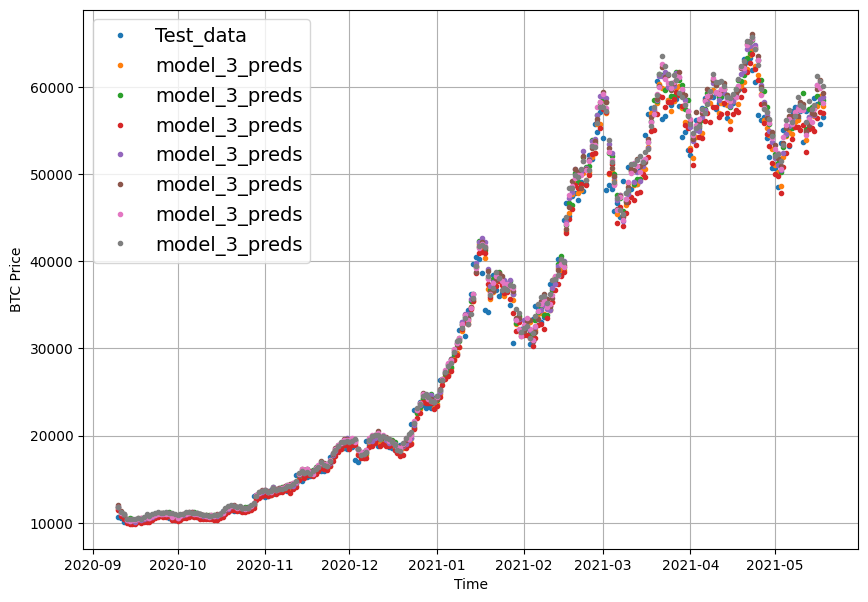

In [63]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

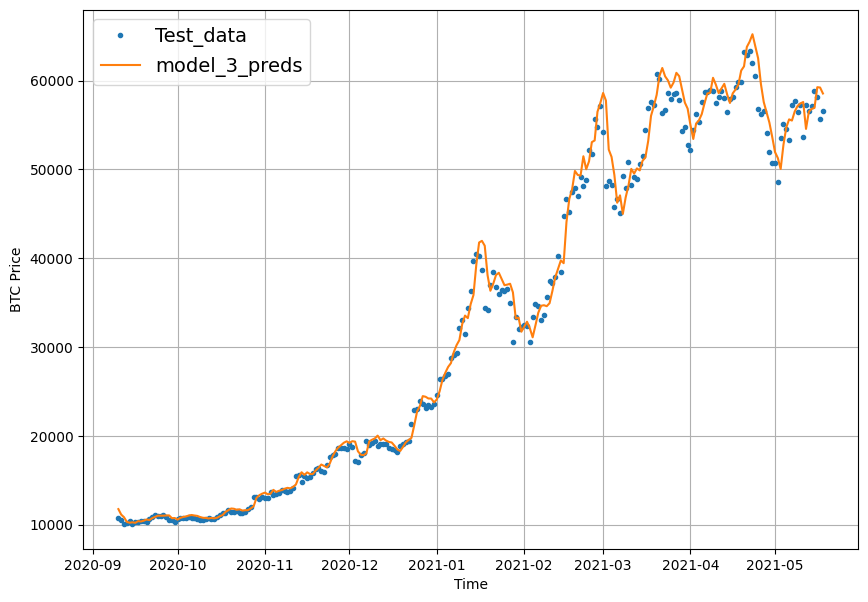

In [64]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Check best performing model

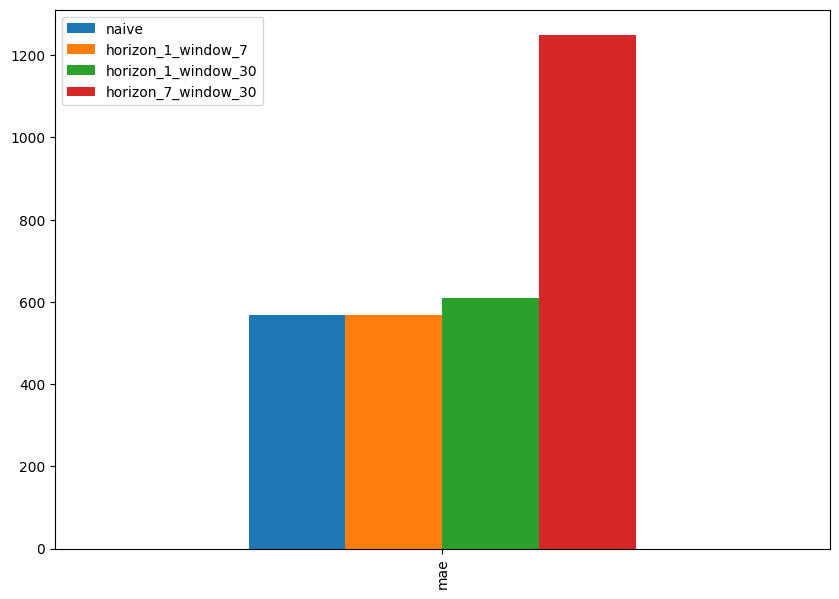

In [65]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

One of the reasons naive is performing best could be due to the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is, a naive model will often get fairly good results.

## Model 4: Conv1D

In [66]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [67]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [68]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [69]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [71]:
# Before I pass our data to the Conv1D layer, I have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [72]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [73]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 575.9929


575.992919921875

In [75]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 6ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8908.01 , 8797.712, 8974.387, 8797.317, 8782.296, 8726.503,
       8683.742, 8539.394, 8477.236, 8507.77 ], dtype=float32)>

In [76]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 575.993,
 'mse': 1198241.9,
 'rmse': 1094.6423,
 'mape': 2.5886745,
 'mase': 0.04801717}

## Model 5: RNN (LSTM)

In [77]:
tf.random.set_seed(42)

# Build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# When saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [78]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 597.5038


597.5037841796875

In [79]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8972.9795, 8825.263 , 8970.398 , 8805.424 , 8756.17  , 8771.48  ,
       8692.048 , 8570.778 , 8488.225 , 8519.06  ], dtype=float32)>

In [80]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 597.5038,
 'mse': 1274741.1,
 'rmse': 1129.0443,
 'mape': 2.6831443,
 'mase': 0.049810402}

## Make a multivariate time series

In [81]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


To give the model more information, I can add the block reward size.

The following block rewards and dates were sourced from cmcmarkets.com

In [82]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [83]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [84]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


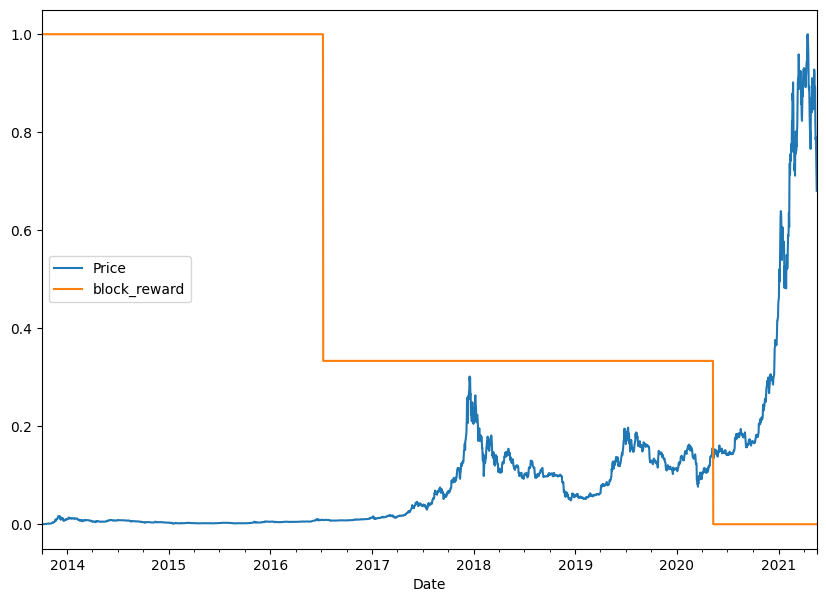

In [85]:
# Plot the block reward/price over time
# Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

In [86]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [87]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [88]:
# Create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [89]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [90]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [91]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile the model
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [92]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 566.8394


566.83935546875

In [93]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8824.753 , 8756.125 , 9008.059 , 8728.718 , 8721.528 , 8732.489 ,
       8647.517 , 8493.275 , 8442.362 , 8504.1045], dtype=float32)>

In [94]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 566.8393,
 'mse': 1159710.0,
 'rmse': 1076.8983,
 'mape': 2.5462334,
 'mase': 0.04725408}

In [95]:
# Compare to model_1
model_1_results

{'mae': 567.34656,
 'mse': 1167292.2,
 'rmse': 1080.413,
 'mape': 2.5426316,
 'mase': 0.04729637}

## Model 7: N-BEATS algorithm

The N-BEATS algorithm focuses on univariate time series problems and achieved state-of-the-art performance in the winner of the M4 competition (a forecasting competition).

### Building and testing an N-BEATS block layer

In [96]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [97]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [98]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [99]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.05225706  0.33998817  0.449757   -0.3873296   0.72955364  0.97857296
 -0.56993335]
Forecast: 0.42175784707069397


### Preparing data for the N-BEATS algorithm using `tf.data`

In [100]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [101]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [102]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [103]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [104]:
# Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The following hyperparameters are taken from Figure 1 and Table 18 of the N-BEATS paper: https://arxiv.org/pdf/1905.10437.pdf

In [105]:
# Values from N-BEATS paper Figure 1 and Table 18
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

There are two layers which play a large roll in the architecture. They're what make N-BEATS **double residual stacking** possible:
* `tf.keras.layers.subtract(inputs)` - subtracts list of input tensors from each other
* `tf.keras.layers.add(inputs)` - adds list of input tensors to each other

In [106]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


The power of residual stacking or residual connections was revealed in Deep Residual Learning for Image Recognition (https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular ResNet architecture) than previous attempts.

A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:
* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers).

It's thought that they help avoid the problem of **vanishing gradients** (patterns learned by a neural network not being passed through to deeper layers).

### Building, compiling, and fitting the N-BEATS algorithm

In [107]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 154: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 254: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1min 45s, sys: 1.92 s, total: 1min 47s
Wall time: 1min 53s


In [108]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 33ms/step - loss: 583.1075 - mae: 583.1075 - mse: 1207210.6250


[583.1074829101562, 583.1074829101562, 1207210.625]

In [109]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8871.155, 8798.273, 9036.5  , 8774.498, 8795.005, 8748.473,
       8634.022, 8542.849, 8476.888, 8512.862], dtype=float32)>

In [110]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 583.1075,
 'mse': 1207210.6,
 'rmse': 1098.7313,
 'mape': 2.6157007,
 'mase': 0.048610266}

### Plotting the N-BEATS architecture

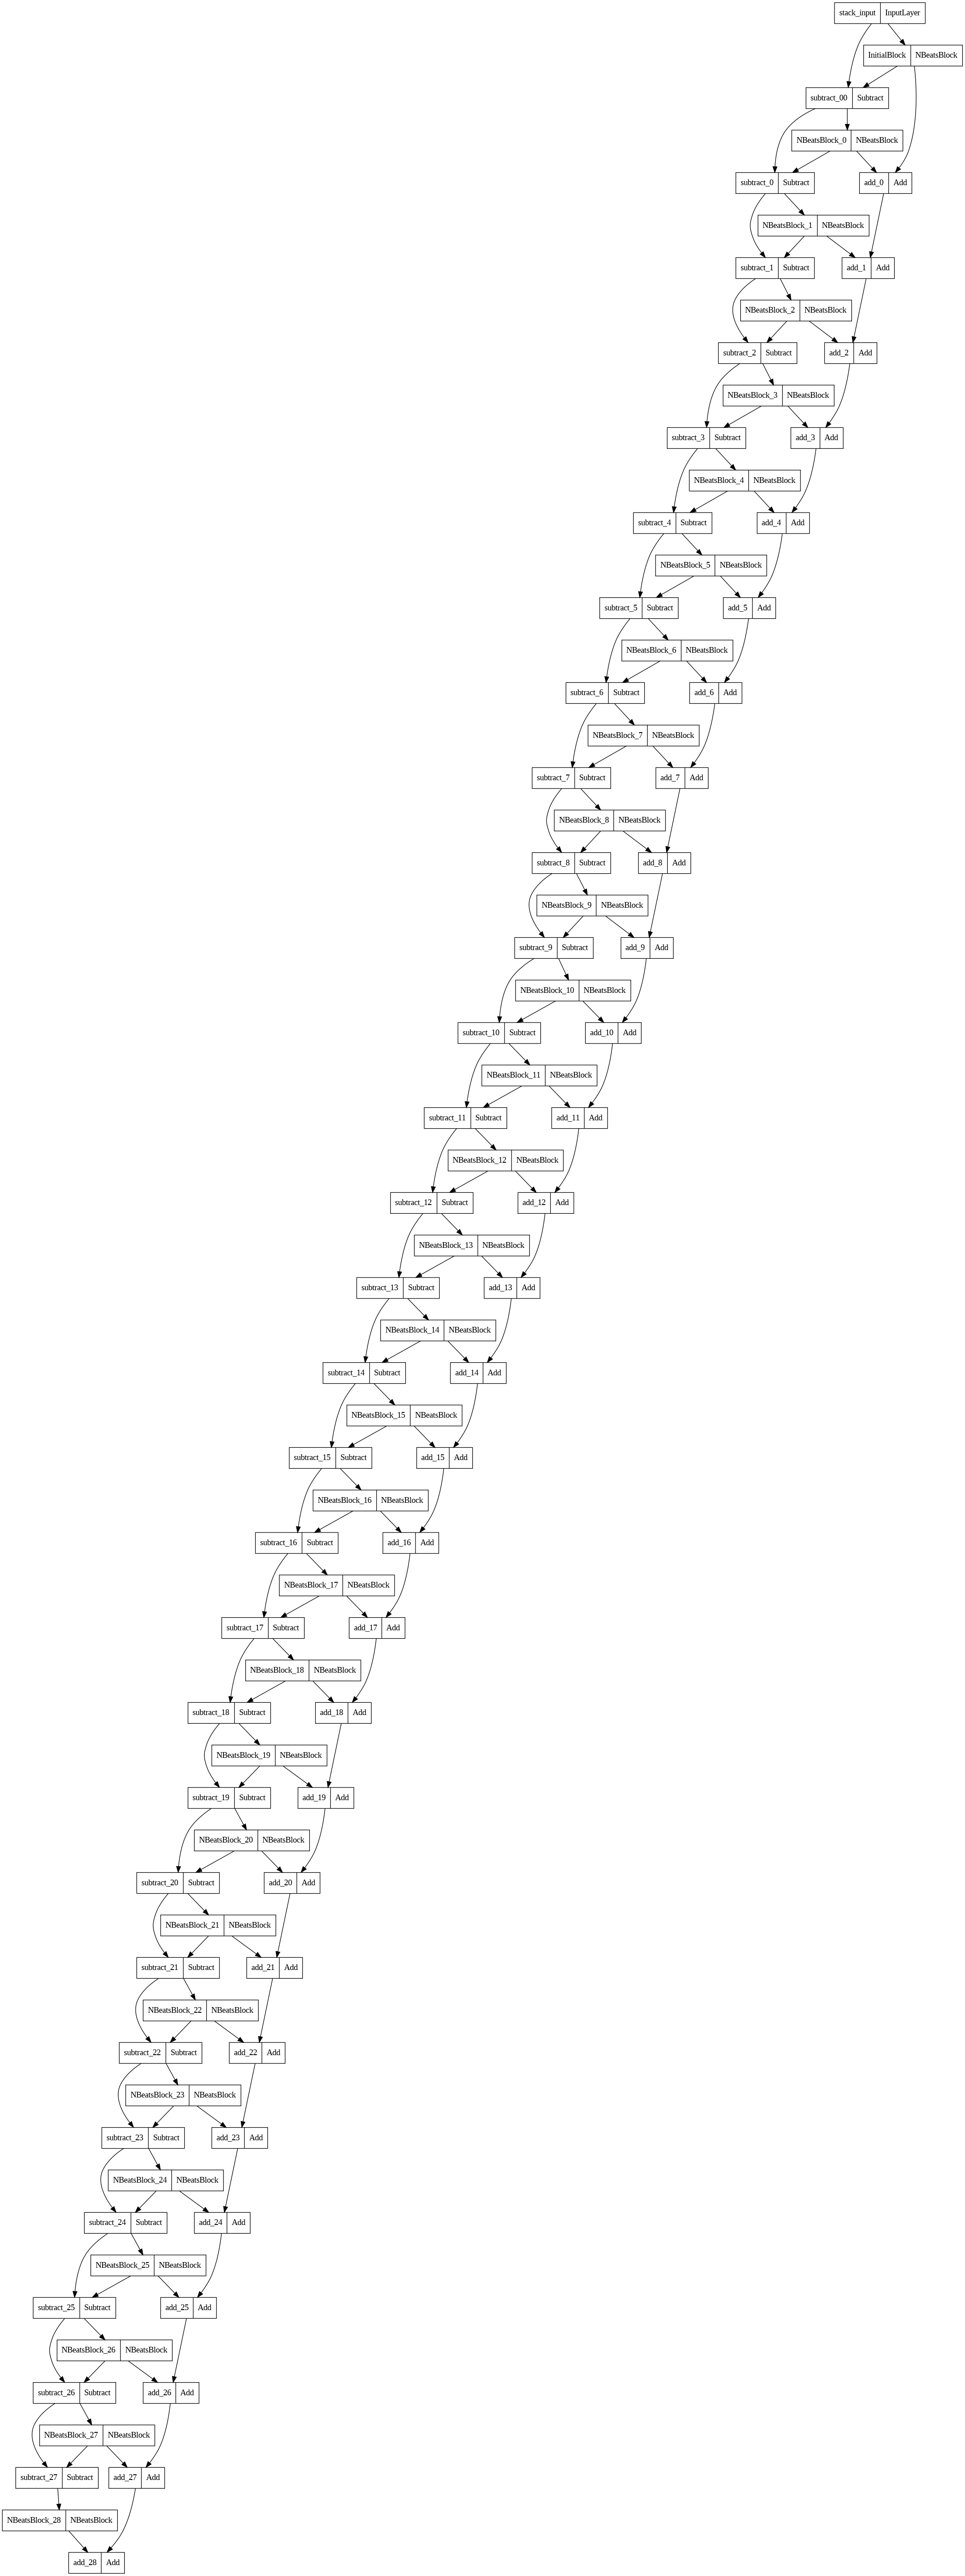

In [111]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An **ensemble** involves training and combining multiple different models on the same problem. Ensemble models are often the types of models you'll see winning data science competitions on websites like Kaggle.

To create the ensemble models I'm going to be using a combination of:
* Different loss functions (MAE, MSE, MAPE)
* Randomly initialized models

### Constructing and fitting an ensemble of models (using different loss functions)

In [112]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [113]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 358: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 595: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 695: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 641: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 948: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 659: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 759: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 401: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 506: ReduceLROnPl

### Making predictions with an ensemble model

In [114]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [115]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 66ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8870.278,  8783.189,  9087.116, ..., 50463.184, 48434.54 ,
        47455.695],
       [ 8748.713,  8776.35 ,  9059.534, ..., 50196.93 , 48118.13 ,
        46130.375],
       [ 8785.425,  8785.02 ,  9026.79 , ..., 50105.54 , 48373.254,
        45767.316],
       ...,
       [ 8820.859,  8741.905,  9046.105, ..., 50027.62 , 49351.164,
        46528.8  ],
       [ 8786.193,  8778.319,  9052.426, ..., 50028.66 , 48378.43 ,
        45825.266],
       [ 8809.471,  8815.562,  9052.612, ..., 50025.25 , 48211.387,
        46111.44 ]], dtype=float32)>

In [116]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 568.36774,
 'mse': 1146910.8,
 'rmse': 1070.9392,
 'mape': 2.5896306,
 'mase': 0.047381498}

### Plotting the prediction intervals (uncertainty estimates) of the ensemble

Knowing the range of values a model is predicting may help you make better decisions for your forecasts.

Although the model is predicting 50,000USD (a **point prediction**, or single value in time), the value could actually be within the range 48,000USD to 52,000USD (of course, the value could also be outside of this range).

These kind of prediction ranges are called **prediction intervals** or **uncertainty estimates**. And they're often as important as the forecast itself.

Point predictions are almost always going to be wrong. So having a range of values can help with decision making.

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (I've got this thanks to the ensemble model)
2. Measure the standard deviation of the predictions
3. Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)

In [117]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std # https://en.wikipedia.org/wiki/1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95%
lower, upper = get_upper_lower(preds=ensemble_preds)

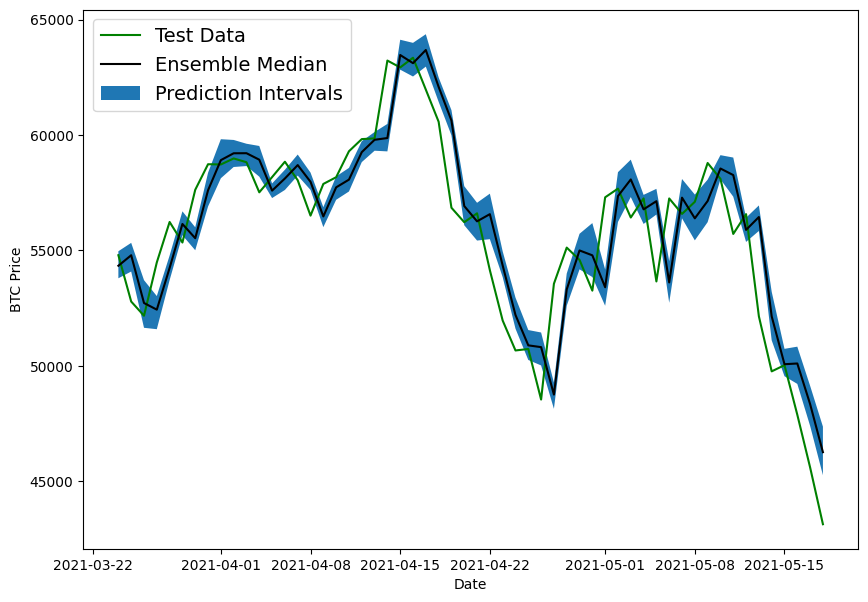

In [118]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);

It looks like the ensemble predictions are lagging slightly behind the actual data.

And the prediction intervals are fairly low throughout.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be **overfitting** the data, meaning it's basically replicating what a naive model would do and just predicting the previous timestep value for the next value.

## Two types of uncertainty - coconut and subway

There are two types of uncertainty in machine learning you should be aware of:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.
  * Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at exactly 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
  * When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.
  * The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach.
    * If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing?
    * But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
  * Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.

  The lines between these are blurred (one type of uncertainty can change forms into the other) and they can be confusing at first but are important to keep in mind for any kind of time series prediction.

## Model 9: Train a model on the full historical data to make predictions into future

Previously, I split the data into training and test sets to evaluate how the model did on pseudo-future data (the test set).

But since the goal of a forecasting model is to predict values into the actual-future, I won't be using a test set.

In [119]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [120]:
# Train model on entire data to make prediction for the next day
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [121]:
# Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [122]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile the model
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions on the future

In [123]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since the Bitcoin data is daily, this is for 14 days

In [124]:
# Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(into_future):

    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

  return future_forecast

In [125]:
# Make forecasts into future of the price of Bitcoin
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 59ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 56291.265625

1/1 [==============================] - 0s 20ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 56291.265625  ] -> Prediction: 50665.1953125

1/1 [==============================] - 0s 33ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 56291.265625   50665.1953125 ] -> Prediction: 49264.78515625

1/1 [==============================] - 0s 42ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 56291.265625   50665.1953125  49264.78515625] -> Prediction: 49369.14453125

1/1 [==============================] - 0s 41ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 56291.265625
 50665.1953125  49264.78515625 49369.144531

In [126]:
future_forecast[:10]

[56291.266,
 50665.195,
 49264.785,
 49369.145,
 45810.055,
 47582.582,
 48177.55,
 54661.984,
 49699.047,
 48408.43]

### Plot future forecasts

In [127]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [128]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [129]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [130]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 56291.266, 50665.195, 49264.785, 49369.145, 45810.055,
        47582.582, 48177.55 , 54661.984, 49699.047, 48408.43 , 48663.277,
        46423.188, 49771.305, 50415.43 ], dtype=float32))

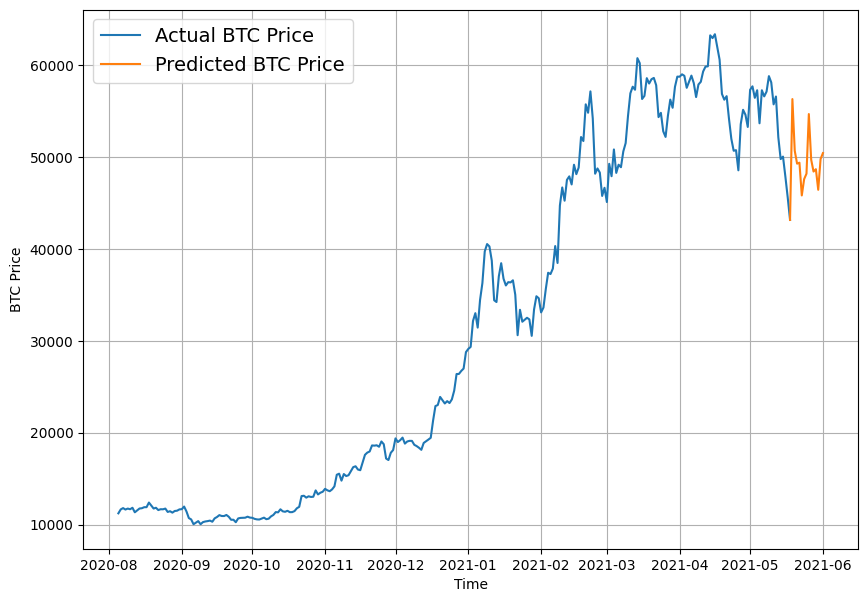

In [131]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

It looks like the predictions are starting to form a bit of a cyclic pattern (up and down in the same way).

Perhaps that's due to the model overfitting the training data and not generalizing well for future data. Also, the further the prediction into the future, the higher the chance for error.

## Model 10: The turkey problem

When creating any kind of forecast, one must keep the **turkey problem** in mind.

The turkey problem is an analogy for when your observational data (your historical data) fails to capture a future event which is catostrophic and could lead you to ruin.

The story goes, a turkey lives a good life for 1000 days, being fed every day and taken care of by its owners until the evening before Thanksgiving.

Based on the turkey's observational data, it has no reason to believe things shouldn't keep going the way they are.

In other words, how could a turkey possibly predict that on day 1001, after 1000 consectutive good days, it was about to have a far from ideal day.

In [132]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [133]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [134]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

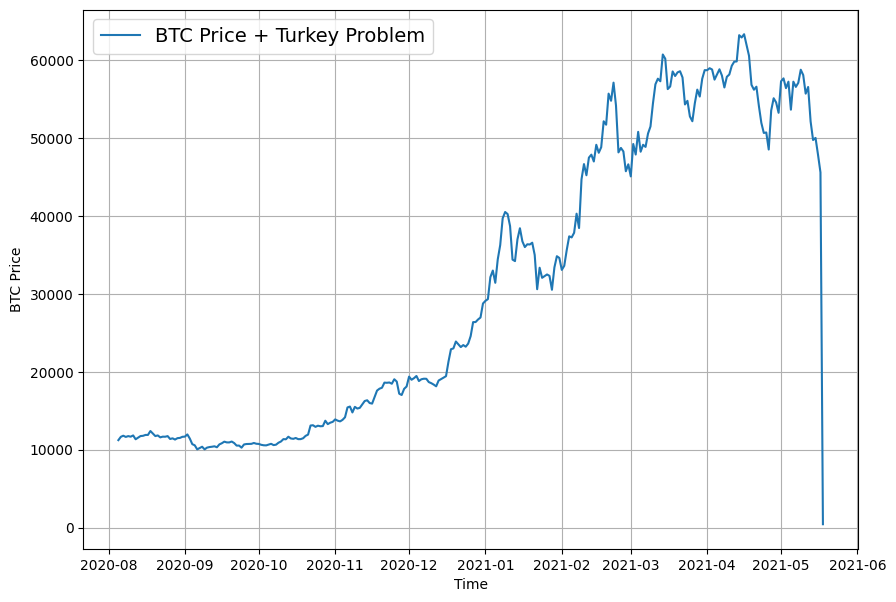

In [135]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey Problem",
                 start=2500)

In [136]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Building a turkey model (model to predict on turkey data)

In [137]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [138]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 664.4578


664.457763671875

In [139]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 640.1450


640.1449584960938

In [140]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8846.378, 8790.468, 9052.347, 8774.51 , 8757.807, 8731.52 ,
       8700.452, 8522.387, 8461.504, 8542.293], dtype=float32)>

In [141]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17147.928,
 'mse': 615666500.0,
 'rmse': 23747.73,
 'mape': 121.617325,
 'mase': 1.435123}

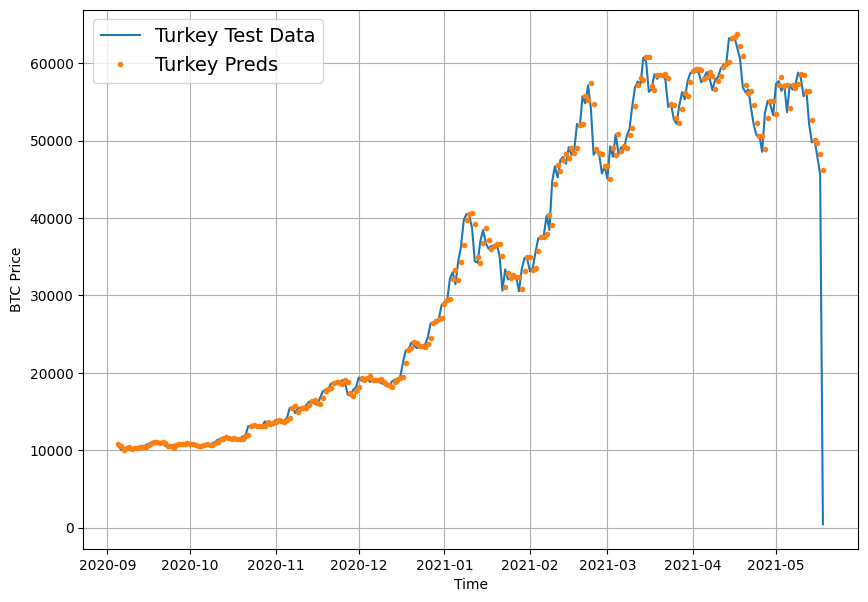

In [142]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

A model cannot predict anything in the future outside of the distribution it was trained on.

In turn, highly unlikely price movements (based on historical movements), upward or downward will likely never be part of a forecast.

## Compare models

In [143]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.047427
model_1_dense_w7_h1,567.346558,1.167292e+06,1080.412964,2.542632,0.047296
model_2_dense_w30_h1,608.349365,1.303945e+06,1141.903931,2.724664,0.050245
model_3_dense_w30_h7,1248.258545,5.529146e+06,1439.274414,5.647796,0.104871
model_4_CONV1D,575.992981,1.198242e+06,1094.642334,2.588675,0.048017
model_5_LSTM,597.503784,1.274741e+06,1129.044312,2.683144,0.049810
model_6_multivariate,566.839294,1.159710e+06,1076.898315,2.546233,0.047254
model_8_NBEATs,583.107483,1.207211e+06,1098.731323,2.615701,0.048610
model_9_ensemble,568.367737,1.146911e+06,1070.939209,2.589631,0.047381
model_10_turkey,17147.927734,6.156665e+08,23747.730469,121.617325,1.435123


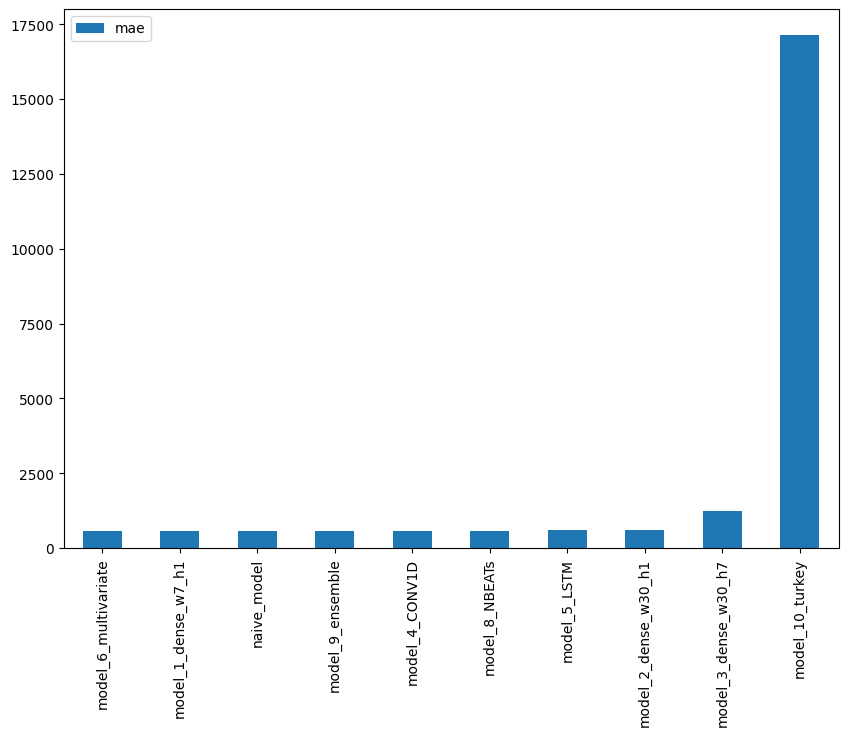

In [144]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");